In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install jdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import jdc # used fo defining functions for a class in separate cells
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.interpolate import make_interp_spline
from tqdm import tqdm # for showing progress bar in for loops
from scipy.stats import pearsonr
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
%matplotlib inline

from random import randrange
from pandas import Series
from matplotlib import pyplot


### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [4]:
def func_1(A, B, r, beta):
    return A * (r - r * A - beta * B)

In [5]:
df1 = pd.read_csv("/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/sea_ice1.csv", index_col='Date', parse_dates=True)

In [6]:
df1.describe()

,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sst,t2m,surface_pressure,sea_ice_extent
count,15584.000000,15584.000000,15584.000000,15584.000000,15584.000000,15584.000000,15584.000000,15584.000000,15584.000000,1.558400e+04
mean,5.159636,2.356239,242.917655,96.988448,1.388352,0.715891,274.783903,265.004380,981.164635,1.138315e+07
std,0.594864,1.507268,44.847910,89.846181,0.409100,0.333644,1.653564,10.789043,4.550959,3.285968e+06
min,3.563044,0.514766,161.390858,0.699326,0.422104,0.021246,272.968951,243.275692,962.788416,3.339905e+06
25%,4.704933,1.054696,200.067186,8.881082,1.067119,0.459149,273.435405,254.476638,978.312383,8.666014e+06
50%,5.136824,1.733097,236.759579,70.114694,1.342988,0.747681,274.067672,264.472376,981.112151,1.210357e+07
75%,5.576375,3.669206,286.968939,183.203147,1.678361,0.949787,276.046552,276.067807,984.007839,1.426088e+07
max,8.025901,5.838770,321.611237,271.515120,3.263371,1.974792,279.302979,281.875844,999.949341,1.663481e+07


##Augmented Dickey-Fuller Test - This test relies on the following:
 
*   Null Hypothesis, H0: The time series is not stationary.
*   Alternative Hypothesis, H1: The time series is stationary.


*   If the p-value is less than or equal to 0.05 or the absolute value of the test statistics is greater than the critical value, you reject H0 and conclude that the time series is stationary.

*   If the p-value is greater than 0.05 or the absolute value of the test statistics is less than the critical value, you fail to reject H0 and conclude that the time series is not stationary.



*   From the results, the p-value is less than 0.05. So we reject the null hypothesis and conclude that the time series is stationary.






In [7]:
#https://blog.quantinsti.com/stationarity/
# Import adfuller
from statsmodels.tsa.stattools import adfuller

for i in df1.columns:
  result = adfuller(df1[[i]])
  print('')
  print('For variable: ', i)
  print('ADF Test Statistic: %.2f' % result[0])
  print('5%% Critical Value: %.2f' % result[4]['5%'])
  print('p-value: %.2f'  % result[1])


For variable:  wind_10m
ADF Test Statistic: -9.12
5% Critical Value: -2.86
p-value: 0.00

For variable:  specific_humidity
ADF Test Statistic: -20.05
5% Critical Value: -2.86
p-value: 0.00

For variable:  LW_down
ADF Test Statistic: -19.93
5% Critical Value: -2.86
p-value: 0.00

For variable:  SW_down
ADF Test Statistic: -25.00
5% Critical Value: -2.86
p-value: 0.00

For variable:  rainfall
ADF Test Statistic: -8.48
5% Critical Value: -2.86
p-value: 0.00

For variable:  snowfall
ADF Test Statistic: -11.74
5% Critical Value: -2.86
p-value: 0.00

For variable:  sst
ADF Test Statistic: -14.53
5% Critical Value: -2.86
p-value: 0.00

For variable:  t2m
ADF Test Statistic: -20.49
5% Critical Value: -2.86
p-value: 0.00

For variable:  surface_pressure
ADF Test Statistic: -17.72
5% Critical Value: -2.86
p-value: 0.00

For variable:  sea_ice_extent
ADF Test Statistic: -18.95
5% Critical Value: -2.86
p-value: 0.00


##Summary Statistics



*   Stationary time series has a constant mean, variance over time. Summary statistics like mean and variance are helpful in estimating whether a time series is stationary or not.
*   We partition the data into random periods and analyse the summary statistics for different periods. If the mean and variance of different partitions are very close to each other, the series is stationary.

*   If there is a significant difference between the mean and variance of the different partitions, then the series is not stationary.









In [8]:
for i in df1.columns:
  X = df1[[i]]
  split = round(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('')
  print('For variable: ', i)
  print('mean1=%f, mean2=%f' % (mean1, mean2))
  print('variance1=%f, variance2=%f' % (var1, var2))


For variable:  wind_10m
mean1=5.157161, mean2=5.162111
variance1=0.355753, variance2=0.352008

For variable:  specific_humidity
mean1=2.255683, mean2=2.456795
variance1=2.191809, variance2=2.331971

For variable:  LW_down
mean1=239.439408, mean2=246.395902
variance1=2046.337176, variance2=1952.391580

For variable:  SW_down
mean1=96.109721, mean2=97.867175
variance1=8025.311927, variance2=8118.852203

For variable:  rainfall
mean1=1.360560, mean2=1.416143
variance1=0.163517, variance2=0.169685

For variable:  snowfall
mean1=0.730603, mean2=0.701179
variance1=0.105310, variance2=0.116908

For variable:  sst
mean1=274.461507, mean2=275.106300
variance1=2.035530, variance2=3.225465

For variable:  t2m
mean1=264.131280, mean2=265.877480
variance1=119.299590, variance2=111.997428

For variable:  surface_pressure
mean1=981.081731, mean2=981.247540
variance1=21.466949, variance2=19.944422

For variable:  sea_ice_extent
mean1=12027425.326360, mean2=10738866.431597
variance1=9193134248349.6210

Here we randomly pick a varible to examine all components and observe the following:


*   It contains no seasonal or cyclical trend
*   It contains zero residuals



###Important Links###


*   https://www.kaggle.com/code/abhishekmamidi/time-series-preprocessing-to-modelling/notebook

*   https://towardsdatascience.com/fun-with-arma-var-and-granger-causality-6fdd29d8391c



*   https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html#






In [9]:
# copy the data
df2 = df1.copy()
  
# apply normalization techniques
for column in df2.columns:
    df2[column] = (df2[column] - df2[column].min()) / (df2[column].max() - df2[column].min())    
  
# view normalized data
print(df2)

            wind_10m  specific_humidity   LW_down   SW_down  rainfall  \
Date                                                                    
1979-01-01  0.517383           0.051057  0.147348  0.002653  0.235034   
1979-01-02  0.580918           0.045493  0.132914  0.002471  0.176469   
1979-01-03  0.476827           0.049367  0.156016  0.001841  0.280466   
1979-01-04  0.462883           0.057262  0.190345  0.002606  0.479249   
1979-01-05  0.603399           0.066704  0.181943  0.002240  0.201925   
...              ...                ...       ...       ...       ...   
2021-08-27  0.408616           0.760484  0.897556  0.374432  0.752336   
2021-08-28  0.374456           0.723474  0.883718  0.375369  0.538440   
2021-08-29  0.249346           0.711088  0.877884  0.362128  0.421172   
2021-08-30  0.186779           0.705741  0.868978  0.363324  0.430016   
2021-08-31  0.194420           0.693447  0.857164  0.347393  0.416637   

            snowfall       sst       t2m  surface_

In [10]:
# df2.index.rename('date', inplace=True)
# df2

In [11]:
df3 = df2.loc['2015-01-01':'2021-08-31']

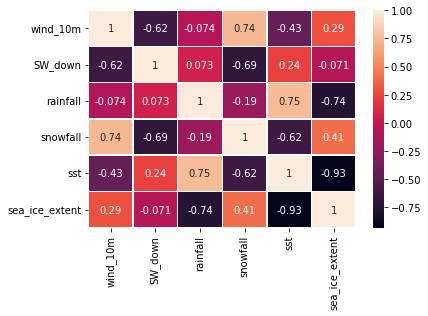

In [48]:
df3 = df3[['wind_10m',	'SW_down',	'rainfall',	'snowfall',	'sst',	'sea_ice_extent']]
corr_df1_norm = df3.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
sns.heatmap(corr_df1_norm,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10});

plt.xticks(rotation=90);
plt.yticks(rotation=0);

In [13]:
df = df2.loc['2015-01-01':'2021-08-31']
# df['Date'] = df.index
# df = df.iloc[: , 1:]
# cols = df.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df = df[cols]
# df

##Synthetic Data generation

In [14]:
path="/content/drive/MyDrive/Fall_2022/IS_800_Causality_New/Team_Project/cybertraining/year-2-projects/team-2/EOF_Data/"
f=sorted([f for f in os.listdir(path) if f.startswith('eof_ts')],key=str.lower)
x=[None]*len(f)
for i in np.arange(0,len(f)):
    print(f[i][7:])
    x[i]=np.loadtxt(path+f[i])

msl-00
msl-01
msl-02
msl-03
msl-04
msl-05
msl-06
msl-07
msl-08
msl-09
msl-10
msl-11
msl-12
msl-13
msl-14
msl-15
msl-16
msl-17
msl-18
msl-19
msl-20
msl-21
msl-22
msl-23
msl-24
msl-25
msl-26
msl-27
msl-28
msl-29
si10-00
si10-01
si10-02
si10-03
si10-04
si10-05
si10-06
si10-07
si10-08
si10-09
si10-10
si10-11
si10-12
si10-13
si10-14
si10-15
si10-16
si10-17
si10-18
si10-19
si10-20
si10-21
si10-22
si10-23
si10-24
si10-25
si10-26
si10-27
si10-28
si10-29
sst-00
sst-01
sst-02
sst-03
sst-04
sst-05
sst-06
sst-07
sst-08
sst-09
sst-10
sst-11
sst-12
sst-13
sst-14
sst-15
sst-16
sst-17
sst-18
sst-19
sst-20
sst-21
sst-22
sst-23
sst-24
sst-25
sst-26
sst-27
sst-28
sst-29
t2m-00
t2m-01
t2m-02
t2m-03
t2m-04
t2m-05
t2m-06
t2m-07
t2m-08
t2m-09
t2m-10
t2m-11
t2m-12
t2m-13
t2m-14
t2m-15
t2m-16
t2m-17
t2m-18
t2m-19
t2m-20
t2m-21
t2m-22
t2m-23
t2m-24
t2m-25
t2m-26
t2m-27
t2m-28
t2m-29


In [15]:
# Hyperparameters for phase space reconstruction and CCM
rlag=1
rdim=3
maxdelay=3

# Parameters for phase space reconstruction and CCM
length=x[0].shape[0]
reconst_length=length-rlag*(rdim-1)
reconst_range=np.arange(rlag*(rdim-1),length)
delay=np.arange(-maxdelay,maxdelay+1)

# The library for cross mapping is a little shorter
lib=np.arange(max(rlag*(rdim-1),maxdelay),length-maxdelay)

print('length='+str(length))
print('reconstucted length='+str(reconst_length))
print('reconstucted range: '+str(reconst_range[0])+' ~ '+str(reconst_range[-1]))
print('library: '+str(lib[0])+' ~ '+str(lib[-1]))
print('CCM delay: '+str(delay[0])+' ~ '+str(delay[-1]))

length=480
reconstucted length=478
reconstucted range: 2 ~ 479
library: 3 ~ 476
CCM delay: -3 ~ 3


In [16]:
import sys
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import csv

# Write outputs to a .csv file
with open('ccm_python.csv',mode='w') as output_file:
    ccm_writer=csv.writer(output_file,delimiter=',')
    ccm_writer.writerow(['Effect','Cause','Timelag','Strength','Method'])

    # CCM computation
    for j in np.arange(0,len(f)):
    
        # Phase space reconstruction for the effect variable x[j]
        reconst=np.zeros([reconst_length,rdim])
        for d in np.arange(0,rdim):
            reconst[:,d]=x[j][d*rlag:d*rlag+reconst_length]

        # Compute Euclidean distances in the reconstructed phase space
        dist=cdist(reconst[lib-rlag*(rdim-1),:],reconst[lib-rlag*(rdim-1),:])
    
        # Exclude the pair of identical phase points
        for k in np.arange(0,len(lib)):
            dist[k,k]=sys.maxsize
                
        # Find the rdim+1 nearest neighbors and assign weights
        index=np.argsort(dist,axis=0)
        sort_dist=np.sort(dist,axis=0)
        weight=np.exp(-sort_dist[:rdim+1]/sort_dist[0])
    
        for i in np.arange(0,len(f)):
        
            # The first dimension is {correlation coefficient, p-value};
            # the second dimension is delay.
            cmskill=np.zeros([2,len(delay)])
            for l in np.arange(0,len(delay)):
                estimate=np.average(x[i][lib[index[:rdim+1]]-delay[l]],axis=0,weights=weight)
                cmskill[:,l]=pearsonr(estimate,x[i][lib-delay[l]])
                
            # Find the optimal delay and corresponding CCM skill
            idx=np.argsort(cmskill[1,:])
            optdelay=delay[idx[0]]
            p=cmskill[1,idx[0]]
            
            # Only preserve meaningful and significant results
            if optdelay>0 and p<0.05:
                ccm_writer.writerow([f[j][7:],f[i][7:],str(optdelay),str(p),'CCM'])
 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv("/content/ccm_python.csv")
df

,Effect,Cause,Timelag,Strength,Method
0,msl-00,msl-01,1,1.171308e-22,CCM
1,msl-00,msl-02,2,2.256661e-42,CCM
2,msl-00,msl-08,1,4.295192e-52,CCM
3,msl-00,msl-09,1,6.543335e-14,CCM
4,msl-00,msl-10,1,3.277078e-45,CCM
...,...,...,...,...,...
5498,t2m-29,t2m-16,2,5.292272e-04,CCM
5499,t2m-29,t2m-20,2,1.791803e-07,CCM
5500,t2m-29,t2m-23,2,1.500256e-02,CCM
5501,t2m-29,t2m-24,1,1.507985e-03,CCM


# CCM Algorithm

### Defining CCM Functions

In [19]:
# Computing "Causality" (Correlation between True and Predictions)
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold    

In [20]:
%%add_to ccm
def shadow_manifold(self, X):
    """
    Given
        X: some time series vector
        tau: lag step
        E: shadow manifold embedding dimension
        L: max time step to consider - 1 (starts from 0)
    Returns
        {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
    """
    X = X[:L] # make sure we cut at L
    M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
    for t in range((self.E-1) * self.tau, self.L):
        x_lag = [] # lagged values
        for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
            x_lag.append(X[t-t2*self.tau])            
        M[t] = x_lag
    return M

In [21]:
%%add_to ccm

# get pairwise distances between vectors in X
def get_distances(self, Mx):
    """
    Args
        Mx: The shadow manifold from X
    Returns
        t_steps: timesteps
        dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
    """

    # we extract the time indices and vectors from the manifold Mx
    # we just want to be safe and convert the dictionary to a tuple (time, vector)
    # to preserve the time inds when we separate them
    t_vec = [(k, v) for k,v in Mx.items()]
    t_steps = np.array([i[0] for i in t_vec])
    vecs = np.array([i[1] for i in t_vec])
    dists = distance.cdist(vecs, vecs)    
    return t_steps, dists

In [22]:
%%add_to ccm

def get_nearest_distances(self, t, t_steps, dists):
    """
    Args:
        t: timestep of vector whose nearest neighbors we want to compute
        t_teps: time steps of all vectors in Mx, output of get_distances()
        dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
        E: embedding dimension of shadow manifold Mx 
    Returns:
        nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
        nearest_distances: array of distances corresponding to vectors closest to vector at time t
    """
    t_ind = np.where(t_steps == t) # get the index of time t
    dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
    
    # get top closest vectors
    nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
    nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
    nearest_distances = dist_t[nearest_inds]  
    
    return nearest_timesteps, nearest_distances


In [23]:
%%add_to ccm
def predict(self, t):
    """
    Args
        t: timestep at Mx to predict Y at same time step
    Returns
        Y_true: the true value of Y at time t
        Y_hat: the predicted value of Y at time t using Mx
    """
    eps = 0.000001 # epsilon minimum distance possible
    t_ind = np.where(self.t_steps == t) # get the index of time t
    dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
    nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
    
    # get weights
    u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
    w = u / np.sum(u)
    
    # get prediction of X
    X_true = self.X[t] # get corresponding true X
    X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat
    
    return X_true, X_hat
    
    

In [24]:
%%add_to ccm
def causality(self):
    '''
    Args:
        None
    Returns:
        correl: how much self.X causes self.Y. correlation between predicted Y and true Y
    '''

    # run over all timesteps in M
    # X causes Y, we can predict X using My
    # X puts some info into Y that we can use to reverse engineer X from Y        
    X_true_list = []
    X_hat_list = []

    for t in list(self.My.keys()): # for each time step in My
        X_true, X_hat = self.predict(t) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat) 

    x, y = X_true_list, X_hat_list
    r, p = pearsonr(x, y)        

    return r, p


### Functions for Visualizing

In [25]:
%%add_to ccm

def visualize_cross_mapping(self):
    """
    Visualize the shadow manifolds and some cross mappings
    """
    # we want to check cross mapping from Mx to My and My to Mx

    f, axs = plt.subplots(1, 2, figsize=(12, 6))        
    
    for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
        #===============================================
        # Shadow Manifolds Visualization

        X_lag, Y_lag = [], []
        for t in range(1, len(self.X)):
            X_lag.append(X[t-tau])
            Y_lag.append(Y[t-tau])    
        X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

        ax.scatter(X_t, X_lag, s=5, label='$M_x$')
        ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

        #===============================================
        # Cross Mapping Visualization

        A, B = [(self.Y, self.X), (self.X, self.Y)][i]
        cm_direction = ['Mx to My', 'My to Mx'][i]

        Ma = self.shadow_manifold(A)
        Mb = self.shadow_manifold(B)

        t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
        t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

        # Plot cross mapping for different time steps
        timesteps = list(Ma.keys())
        for t in np.random.choice(timesteps, size=3, replace=False):
            Ma_t = Ma[t]
            near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

            for i in range(E+1):
                # points on Ma
                A_t = Ma[near_t_A[i]][0]
                A_lag = Ma[near_t_A[i]][1]
                ax.scatter(A_t, A_lag, c='b', marker='s')

                # corresponding points on Mb
                B_t = Mb[near_t_A[i]][0]
                B_lag = Mb[near_t_A[i]][1]
                ax.scatter(B_t, B_lag, c='r', marker='*', s=50)  

                # connections
                ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':') 

        ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {tau}, E = 2')
        ax.legend(prop={'size': 14})

        ax.set_xlabel('$X_t$, $Y_t$', size=15)
        ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)               
    plt.show()       

In [26]:
%%add_to ccm
def plot_ccm_correls(self):
    """
    Args
        X: X time series
        Y: Y time series
        tau: time lag
        E: shadow manifold embedding dimension
        L: time duration
    Returns
        None. Just correlation plots
    """
    M = self.shadow_manifold(self.Y) # shadow manifold
    t_steps, dists = self.get_distances(M) # for distances

    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X

    X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
    Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

    for t in range(tau, L):
        true, pred = ccm_XY.predict(t)
        X_My_true.append(true)
        X_My_pred.append(pred)    

        true, pred = ccm_YX.predict(t)
        Y_Mx_true.append(true)
        Y_Mx_pred.append(pred)        

    # # plot
    figs, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # predicting X from My
    r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)
    
    axs[0].scatter(X_My_true, X_My_pred, s=10)
    axs[0].set_xlabel('$X(t)$ (observed)', size=12)
    axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=12)
    axs[0].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')

    # predicting Y from Mx
    r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)
    
    axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
    axs[1].set_xlabel('$Y(t)$ (observed)', size=12)
    axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=12)
    axs[1].set_title(f'tau={tau}, E={E}, L={L}, Correlation coeff = {r}')
    plt.show()


In [27]:
# #df['date'] = range(1999, 2010)
# make_plots(df, 'date', 'sea_ice_extent', 'snowfall')
## Helper plotting function
def make_plots(df, dt_name, val1_name, val2_name):
    # drop nulls
    df = df[[dt_name, val1_name, val2_name]].dropna()
    
    # smoothen
    date_smooth = np.linspace(df[dt_name].min(), df[dt_name].max(), 100) 
    spl = make_interp_spline(df[dt_name], df[val1_name], k=2)
    val1 = spl(date_smooth)
    spl = make_interp_spline(df[dt_name], df[val2_name], k=2)
    val2 = spl(date_smooth)    
    r, p = np.round(pearsonr(df[val1_name], df[val2_name]), 4)
    
    # plot
    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(date_smooth, val1, )
    ax = df.plot(x=dt_name, y=val1_name, marker='', c='b', linestyle='', legend=False, ax=ax)
    ax.set_ylabel(val1_name)
    ax2 = ax.twinx()
    ax2.plot(date_smooth, val2, c='r')
    df.plot(x=dt_name, y=val2_name, marker='', c='r', linestyle='', legend=False, ax=ax2)
    ax2.set_ylabel(val2_name)    
    ax.figure.legend()        
    plt.title(f"{val1_name} and {val2_name}, correlation coefficient: {r}", size=16)
    plt.tight_layout()
    plt.show()

##snowfall and sea_ice_extent in the artic regions##	
We investigate the bi-directional effects of the quantity of snow fall on the content of sea ice for the period between 1979 and 2021. 

Do we expect these two to be causally linked?

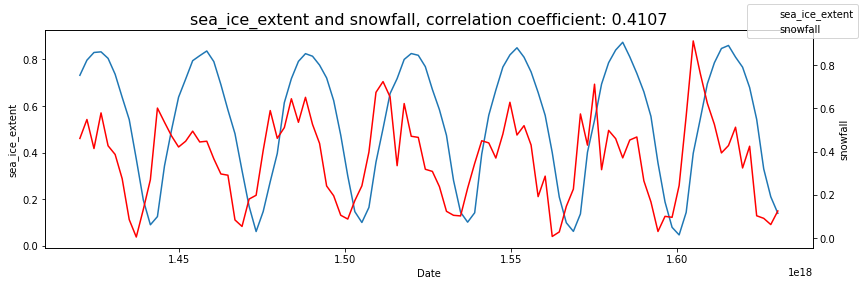

In [28]:
df = df3[['sea_ice_extent', 'snowfall']]
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: x.value)
make_plots(df, "Date", 'sea_ice_extent', 'snowfall')

X->Y r 0.69 p value 0.0
Y->X r 0.34 p value 0.0


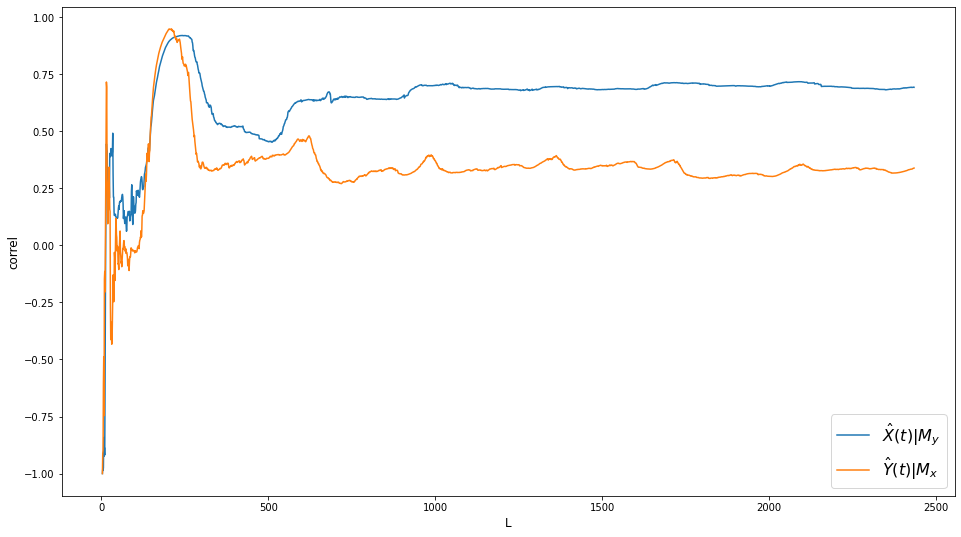

In [29]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['snowfall'].values

# Looking at "convergence"
L_range = range(3, L+1, 1) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})  

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

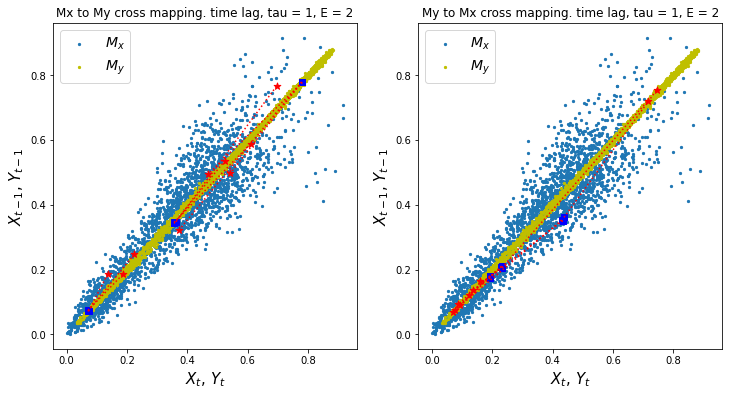

In [30]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sea_ice_extent'].values
X = df['snowfall'].values

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

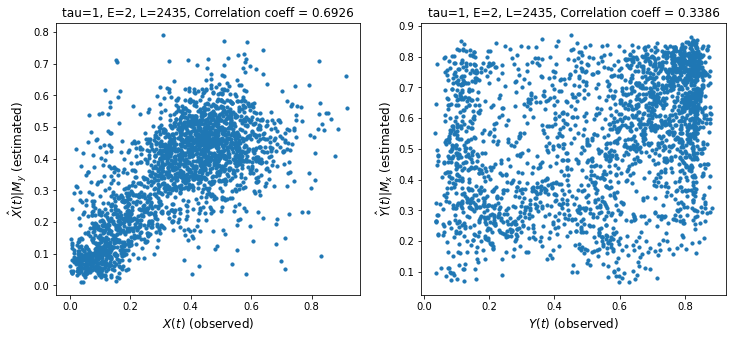

In [31]:
# let us plot the performance of the cross mapping predictions using correlation
L = df.shape[0] # length of time period to consider
tau = 1
E = 2
ccm1.plot_ccm_correls()

##wind_10m vs sea_ice_extent##

###Here we investigate the effects of wind speed at 10m above sea level to the content of sea ice###

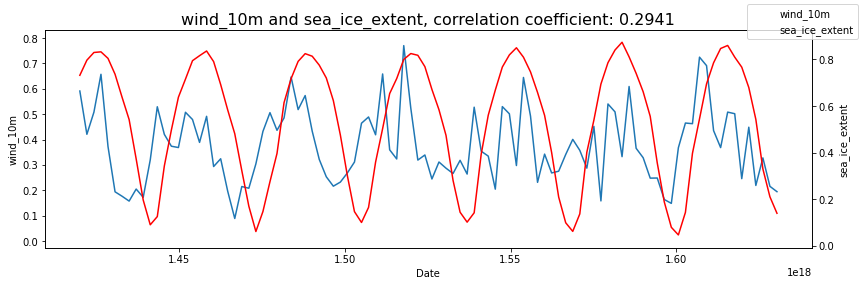

In [32]:
df = df3[['wind_10m', 'sea_ice_extent']]
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: x.value)
make_plots(df, 'Date', 'wind_10m', 'sea_ice_extent')

X->Y r 0.12 p value 0.0
Y->X r 0.4 p value 0.0


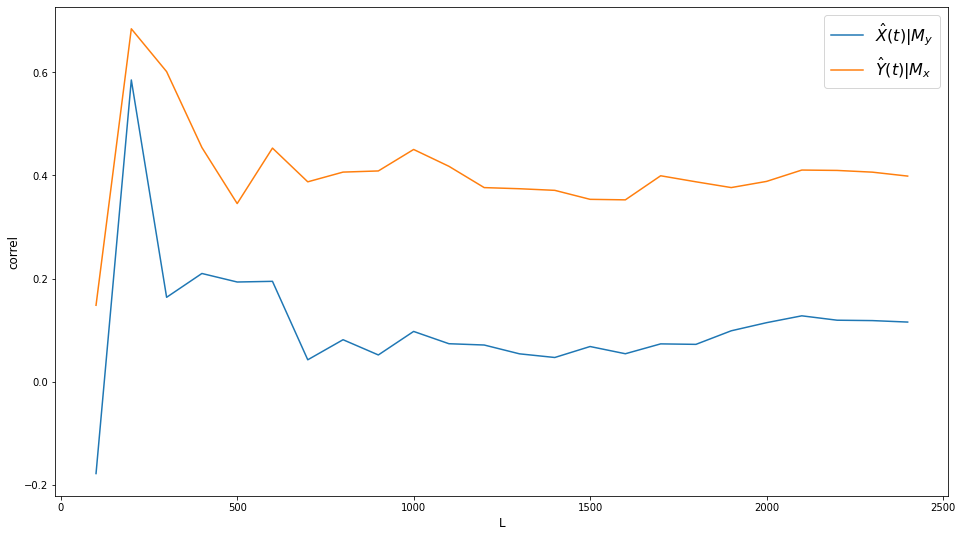

In [33]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['wind_10m'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 4))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 4))

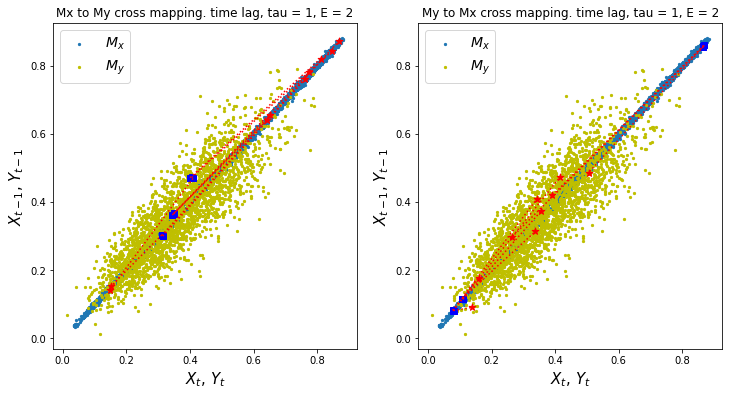

In [34]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['wind_10m'].values
X = df['sea_ice_extent'].values

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

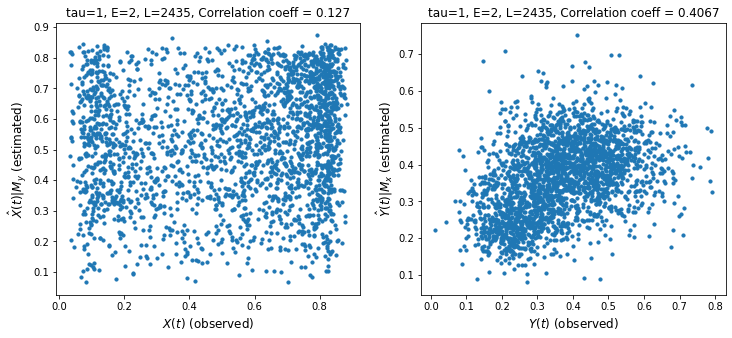

In [35]:
# let us plot the performance of the cross mapping predictions using correlation
L = df.shape[0] # length of time period to consider
tau = 1
E = 2
ccm1.plot_ccm_correls()

#**sw_down vs sea_ice_extent**#

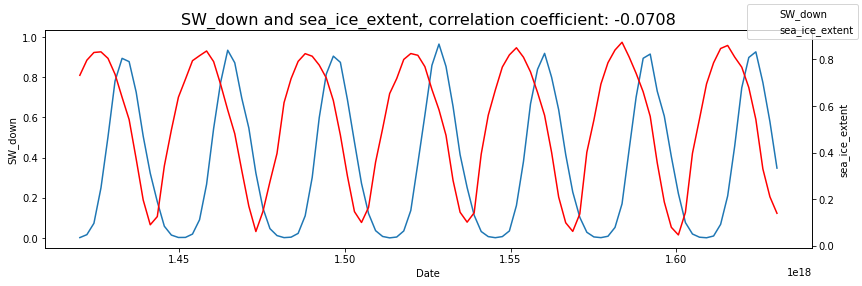

In [36]:
df = df3[['SW_down', 'sea_ice_extent']]
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: x.value)
make_plots(df, 'Date', 'SW_down', 'sea_ice_extent')

X->Y r 0.6 p value 0.0
Y->X r 0.7 p value 0.0


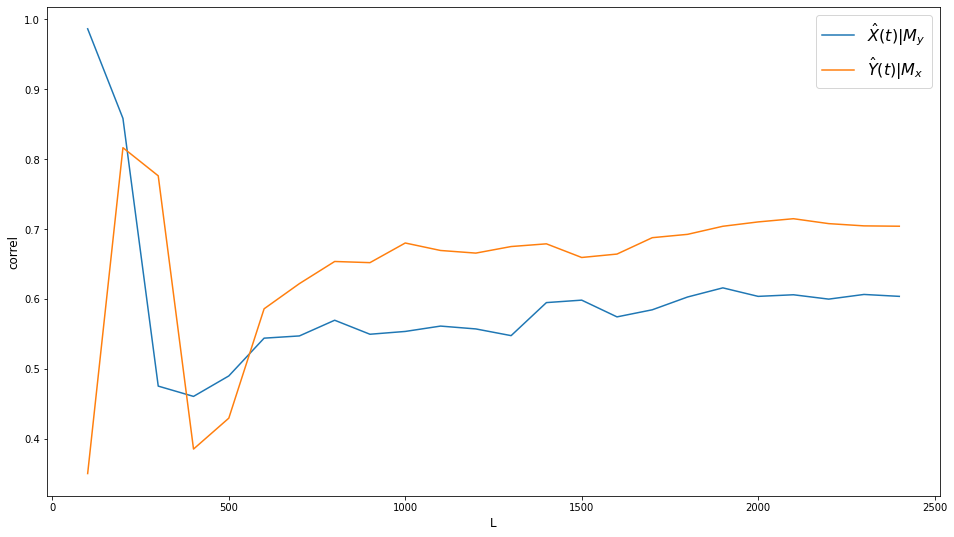

In [37]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['SW_down'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

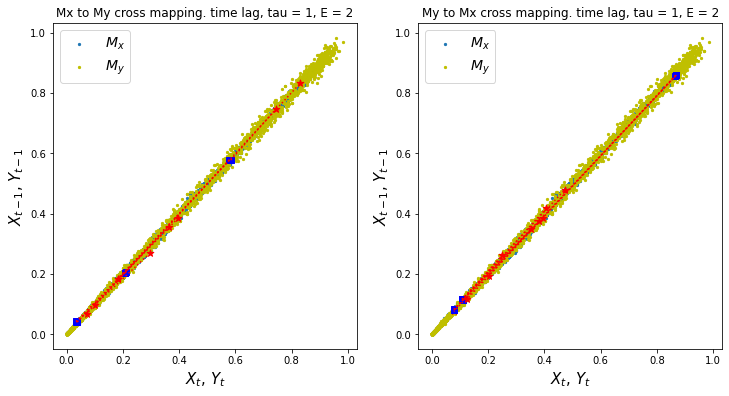

In [38]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['SW_down'].values
X = df['sea_ice_extent'].values

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

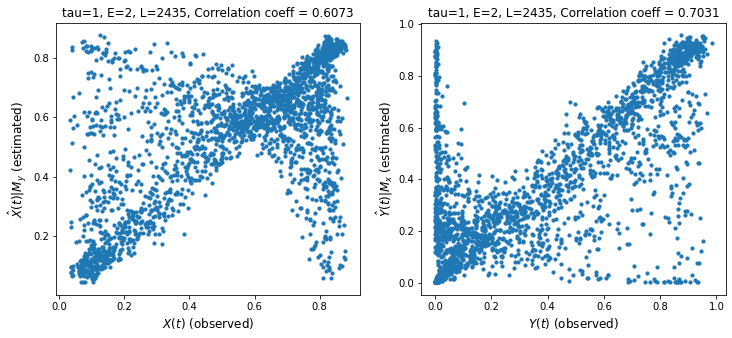

In [39]:
# let us plot the performance of the cross mapping predictions using correlation
L = df.shape[0] # length of time period to consider
tau = 1
E = 2
ccm1.plot_ccm_correls()

#### SST vs sea_ice_extent

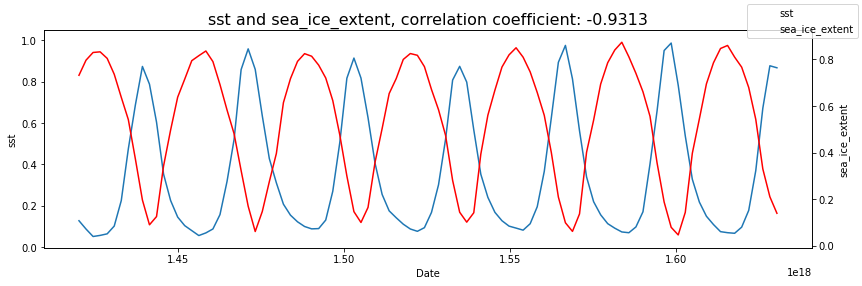

In [40]:
df = df3[['sst', 'sea_ice_extent']]
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: x.value)
make_plots(df, 'Date', 'sst', 'sea_ice_extent')

X->Y r 0.98 p value 0.0
Y->X r 0.97 p value 0.0


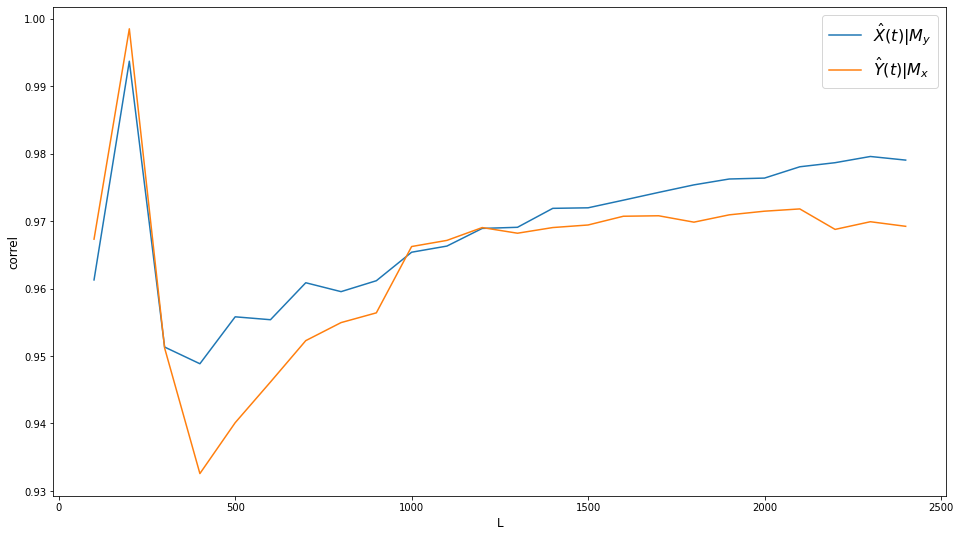

In [41]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sst'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

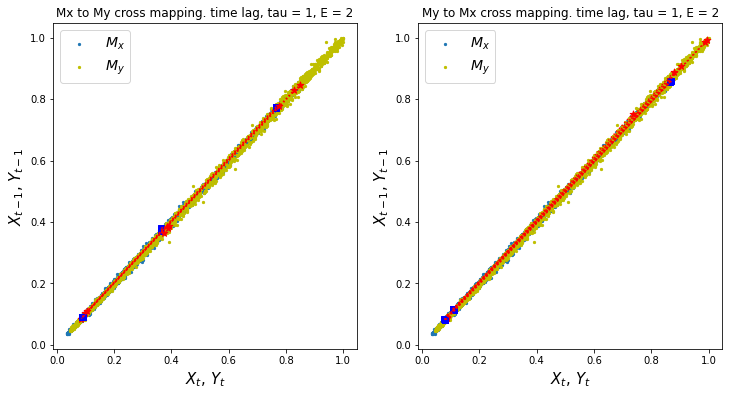

In [42]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sst'].values
X = df['sea_ice_extent'].values

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

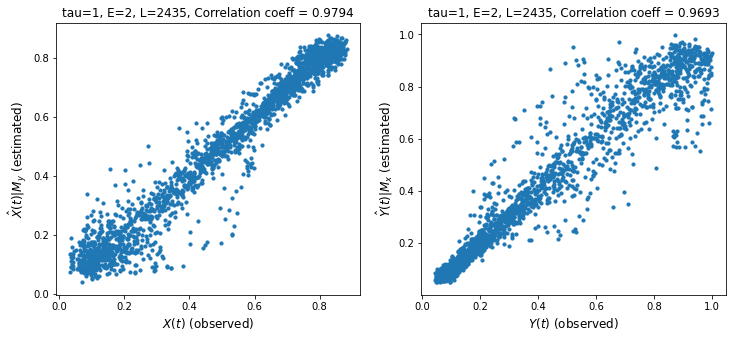

In [43]:
# let us plot the performance of the cross mapping predictions using correlation
L = df.shape[0] # length of time period to consider
tau = 1
E = 2
ccm1.plot_ccm_correls()

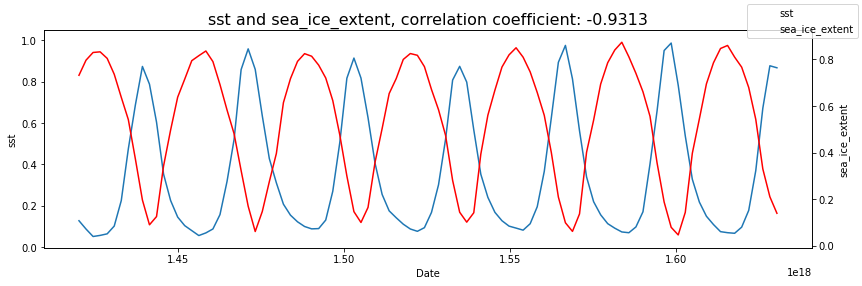

In [ ]:
df = df3[['sst', 'sea_ice_extent']]
df['Date'] = df.index
df['Date'] = df['Date'].apply(lambda x: x.value)
make_plots(df, 'Date', 'sst', 'sea_ice_extent')

X->Y r 0.98 p value 0.0
Y->X r 0.97 p value 0.0


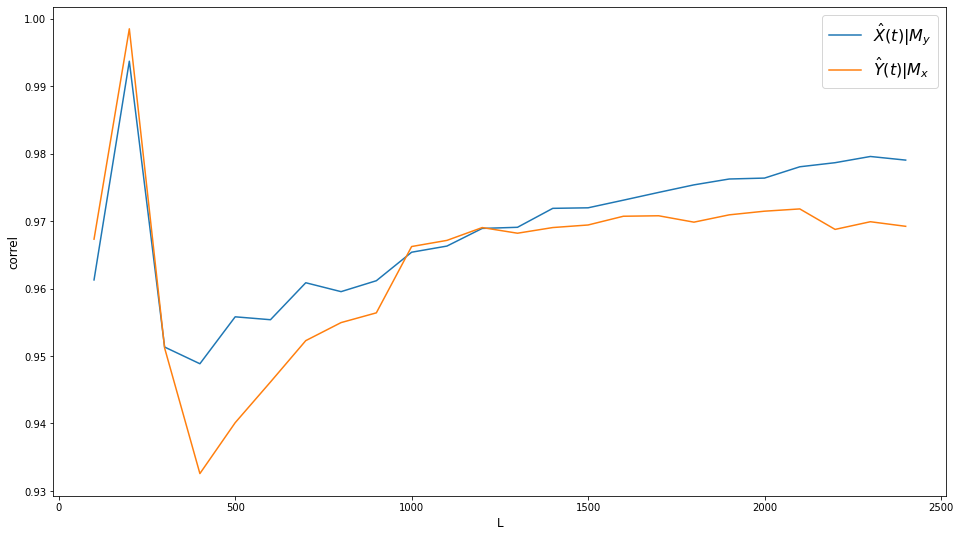

In [ ]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sst'].values
X = df['sea_ice_extent'].values

# Looking at "convergence"
L_range = range(100, L+1, 100) # L values to test
Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0])    
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(16,9))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16}) 

print('X->Y r', np.round(Xhat_My[-1], 2), 'p value', np.round(ccm_XY.causality()[1], 2))
print('Y->X r', np.round(Yhat_Mx[-1], 2), 'p value', np.round(ccm_YX.causality()[1], 2))

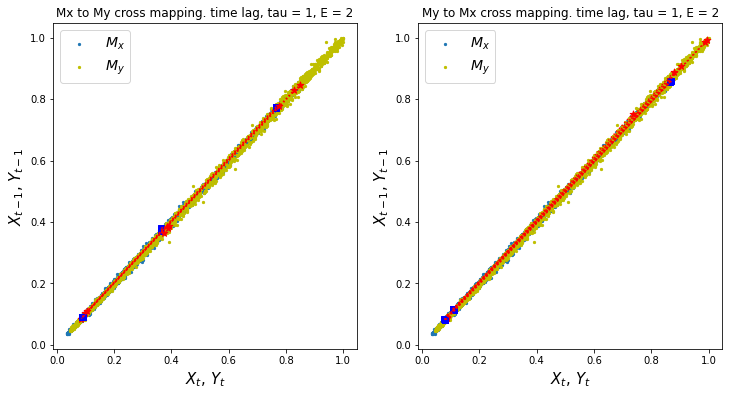

In [ ]:
# Visualize simple shadow manifolds Mx and My for different tau
# We visualize Cross-Mapping

np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 1 # time lag
E = 2 # shadow manifold embedding dimensions
L = df.shape[0] # length of time period to consider

Y = df['sst'].values
X = df['sea_ice_extent'].values

ccm1 = ccm(X, Y, tau, E, L)
ccm1.visualize_cross_mapping()

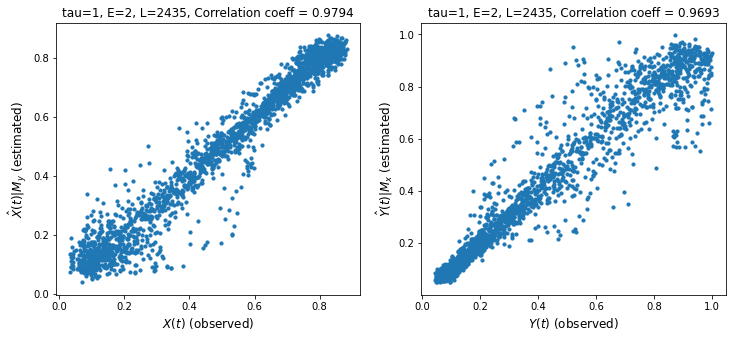

In [ ]:
# let us plot the performance of the cross mapping predictions using correlation
L = df.shape[0] # length of time period to consider
tau = 1
E = 2
ccm1.plot_ccm_correls()

#How Betas Affect Causality As Indicated By Convergence

#What if asymmetrically coupled (the effect is only in one direction)?

#Strong Forcing
What happens to the result of CCM when 𝑋 has very strong effects on 𝑌 yet 𝑌 has 0 effect on 𝑋?

In [44]:
# Initialize test dataset
# params

# values for B_yx
# we query an array using B_yx_dict[B_yx value][X or Y]
B_yx_dict = {np.round(k, 2):{'X':[], 'Y':[]} for k in np.arange(0, 1.6, 0.2)}

r_x = 3.7
r_y = 3.7

X0 = 0.2 # initial val following Sugihara et al
Y0 = 0.4 # initial val following Sugihara et al
t = 2000 # time steps

for k in B_yx_dict.keys():    
    B_xy = 0 # effect on x given y (effect of y on x)
    B_yx = k # effect on y given x (effect of x on y)    
    
    X = [X0]
    Y = [Y0]
    for i in range(t):
        X_ = func_1(X[-1], Y[-1], r_x, B_xy)
        Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
        X.append(X_)
        Y.append(Y_) 
    B_yx_dict[k]['X'] += X
    B_yx_dict[k]['Y'] += Y

In [45]:
# Looking at "convergence" for different B_yx values
L_range = range(100, 1000, 100) # L values to test
tau = 1
E = 2

B_yx_list = []
L_list = []
Yhat_Mx_list = []
Xhat_My_list = []


for B_yx in B_yx_dict.keys():
    X = B_yx_dict[B_yx]['X']
    Y = B_yx_dict[B_yx]['Y']    

    for L in L_range: 
        ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
        ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
        
        B_yx_list.append(B_yx)
        L_list.append(L)
        Xhat_My_list.append(ccm_XY.causality()[0]) # wont be used        
        Yhat_Mx_list.append(ccm_YX.causality()[0])


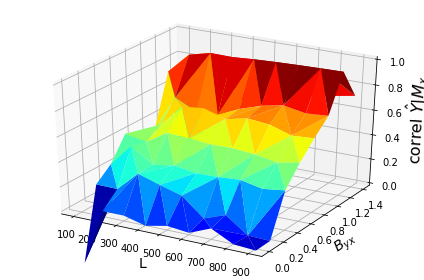

In [46]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

x = np.array(L_list)
y = np.array(B_yx_list)
z = np.array(Yhat_Mx_list)

ax.plot_trisurf(x, y, z, cmap='jet', antialiased=True)
ax.set_xlabel('L', size=14)
ax.set_ylabel('$B_{yx}$', size=14)
ax.set_zlabel('correl $\hat{Y}|M_x$', size=16)
ax.set_zlim(0, 1)
plt.tight_layout()